In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import json
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from pycocotools.coco import COCO
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from skimage.io import imread  
import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import plotly.express as px
import seaborn as sns

In [2]:
train_dir = '../pidray/train/'
easy_test_dir = '../pidray/easy/'
hard_test_dir = '../pidray/hard/'
hidden_test_dir = '../pidray/hidden/'
train_json = "../pidray/annotations/xray_train.json"
easy_json = "../pidray/annotations/xray_test_easy.json"
hard_json = "../pidray/annotations/xray_test_hard.json"
hidden_json = "../pidray/annotations/xray_test_hidden.json"
train_n = len(os.listdir(train_dir))
easy_n = len(os.listdir(easy_test_dir))
hard_n = len(os.listdir(hard_test_dir))
hidden_n = len(os.listdir(hidden_test_dir))
total_img = train_n + easy_n + hard_n + hidden_n 


```
- pidray (data)
    └── annotations
        ├── xray_test_easy.json
        ├── xray_test_hard.json
        ├── xray_test_hidden.json
        └── xray_train.json
    └── easy
        ├── xray_easy00000.png
        ├── xray_easy00001.png
        └── ...
    └── hard
        ├── xray_hard00000.png
        ├── xray_hard00001.png
        └── ...
    └── hidden
        ├── xray_hidden00000.png
        ├── xray_hidden00001.png
        └── ...
    └── train
        ├── xray_00000.png
        ├── xray_00001.png
        └── ...
```

```
- Parent dir
    └── train
        └── images
            ├── xray_00000.png
            ├── xray_00001.png
            └── ... 
        └── labels
            ├── xray_00001.txt
            ├── xray_00001.txt
            └── ... 
    └── valid
        └── images
            ├── xray_easy_00000.png
            ├── xray_easy_00001.png
            └── ...
        └── labels
            ├── xray_easy_00000.txt
            ├── xray_easy_00001.txt
            └── ...
    └── test
        └── images
            ├── xray_hard_00000.png
            ├── xray_hard_00001.png
            └── ...
        └── labels
            ├── xray_hard_00000.txt
            ├── xray_hard_00001.txt
            └── ...
```

In [3]:
print(f"The train have {train_n} ({np.round(train_n/total_img, 3)*100 }% of total dataset) ")
print(f"The easy have {easy_n} ({np.round(easy_n/total_img*100, 1)}% of total dataset)")
print(f"The hard have {hard_n} ({np.round(hard_n/total_img, 3)*100 }% of total dataset)")
print(f"The hidden have {hidden_n} ({np.round(hidden_n/total_img, 3)*100 }% of total dataset)")
print(f"Total number of images: {total_img} ")

The train have 29457 (61.8% of total dataset) 
The easy have 9482 (19.9% of total dataset)
The hard have 3733 (7.8% of total dataset)
The hidden have 5005 (10.5% of total dataset)
Total number of images: 47677 


In [4]:
coco = COCO(train_json)


loading annotations into memory...
Done (t=0.53s)
creating index...
index created!


In [5]:
gun_id = coco.getCatIds(['Gun'])
image_id = coco.getImgIds(catIds=gun_id)
print(image_id[0])

21167


In [6]:
anno_id = coco.getAnnIds(imgIds=image_id[0], catIds=gun_id)


In [7]:
ann_list = coco.loadAnns(anno_id)
for i in ann_list:
    print(i['bbox'])

[285.49541284403665, 304.58715596330273, 112.8440366972477, 42.20183486238534]


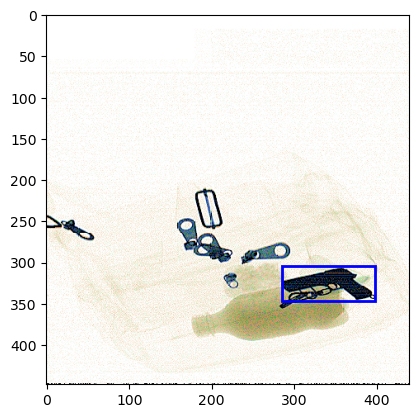

In [57]:
img_id = image_id[0]
img_name = 'xray_'+str(img_id)+".png"
img = Image.open(train_dir+img_name)

fig, ax = plt.subplots()

for i in ann_list:
    box = i['bbox']
    bb = patches.Rectangle(
        (box[0],box[1]),
        box[2],
        box[3],
        linewidth=2,
        edgecolor='blue',
        facecolor='none'
    )
    ax.add_patch(bb)

ax.imshow(img)
plt.show()

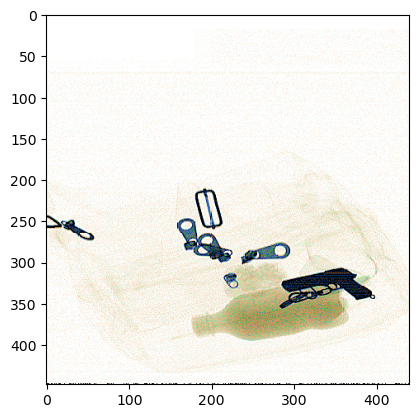

In [59]:
img = Image.open(train_dir+img_name)

fig, ax = plt.subplots()
ax.imshow(img)
plt.show()

In [9]:
f = open(train_json)
anns = json.load(f)
print(anns.keys())
anns['categories']

dict_keys(['info', 'license', 'annotations', 'categories', 'images'])


[{'id': 1, 'name': 'Baton'},
 {'id': 2, 'name': 'Pliers'},
 {'id': 3, 'name': 'Hammer'},
 {'id': 4, 'name': 'Powerbank'},
 {'id': 5, 'name': 'Scissors'},
 {'id': 6, 'name': 'Wrench'},
 {'id': 7, 'name': 'Gun'},
 {'id': 8, 'name': 'Bullet'},
 {'id': 9, 'name': 'Sprayer'},
 {'id': 10, 'name': 'HandCuffs'},
 {'id': 11, 'name': 'Knife'},
 {'id': 12, 'name': 'Lighter'}]

In [10]:
df = pd.DataFrame(anns['annotations'])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39708 entries, 0 to 39707
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            39708 non-null  int64  
 1   image_id      39708 non-null  int64  
 2   category_id   39708 non-null  int64  
 3   segmentation  39708 non-null  object 
 4   bbox          39708 non-null  object 
 5   iscrowd       39708 non-null  int64  
 6   area          39708 non-null  float64
dtypes: float64(1), int64(4), object(2)
memory usage: 2.1+ MB


In [12]:
def id_to_label(id):
    if id == 1:
        return "Baton"
    elif id == 2:
        return "Pliers"
    elif id == 3:
        return "Hammer"
    elif id == 4:
        return "Powerbank"
    elif id == 5:
        return "Scissors"
    elif id == 6:
        return "Wrench"
    elif id == 7:
        return "Gun"
    elif id == 8:
        return "Bullet"
    elif id == 9:
        return "Sprayer"
    elif id == 10:
        return "HandCuffs"
    elif id == 11:
        return "Knife"
    elif id == 12:
        return "Lighter"


<AxesSubplot: >

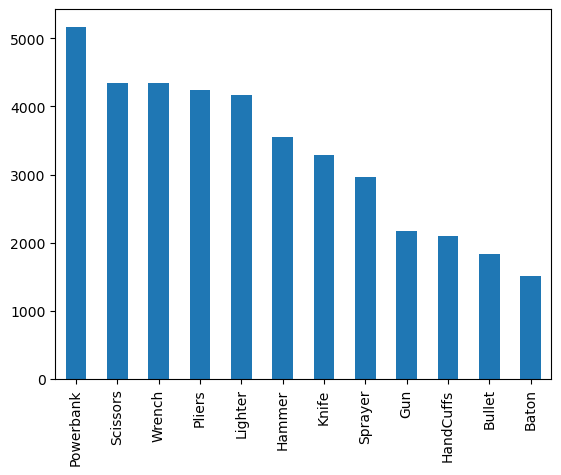

In [13]:
df['label'] = df.category_id.apply(id_to_label)
df['label'].value_counts().plot(kind='bar')

In [44]:
sns.color_palette()

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

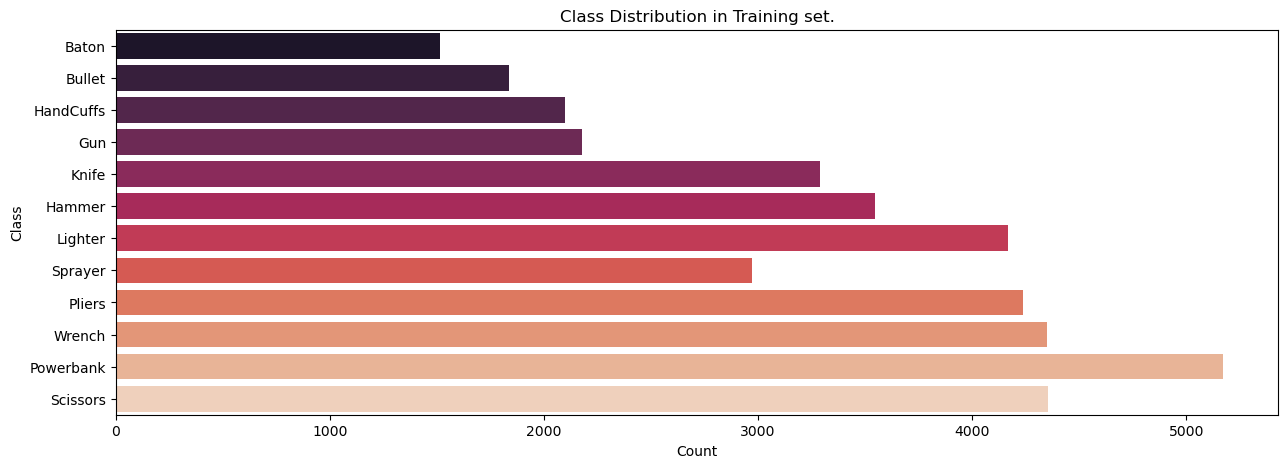

In [56]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(y= 'label', data=df, palette='rocket').set(title='Class Distribution in Training set.', xlabel='Count', ylabel='Class')
plt.show()

# After training

[Text(0.5, 1.0, 'mAP_0.5 vs Epoch Using YOLOv5'),
 Text(0.5, 0, 'Epoch'),
 Text(0, 0.5, 'mAP value')]

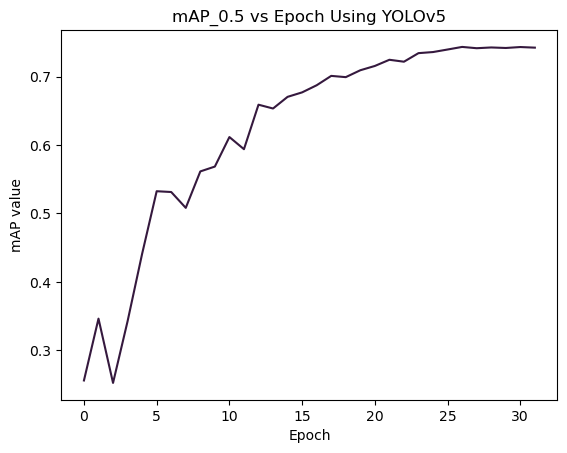

In [65]:
mAP = pd.read_csv("../plots/mAP50.csv")
sns.lineplot(data=mAP, x='Step',y='Value').set(title='mAP_0.5 vs Epoch Using YOLOv5', xlabel="Epoch",ylabel= "mAP value")

In [67]:
mAP['Value'].max()

0.7434504628181458

In [68]:
obj_loss = pd.read_csv("../plots/val_obj_loss.csv")
cls_loss = pd.read_csv("../plots/val_cls_loss.csv")
box_loss = pd.read_csv("../plots/val_box_loss.csv")

[Text(0.5, 1.0, 'Objectness loss vs Epoch Using YOLOv5'),
 Text(0.5, 0, 'Epoch'),
 Text(0, 0.5, 'Objectness loss value')]

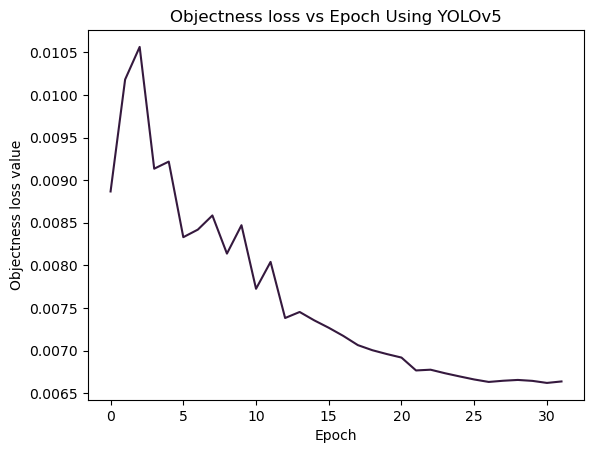

In [69]:
sns.lineplot(data=obj_loss, x='Step',y='Value').set(title='Objectness loss vs Epoch Using YOLOv5', xlabel="Epoch",ylabel= "Objectness loss value")

[Text(0.5, 1.0, 'Classification loss vs Epoch Using YOLOv5'),
 Text(0.5, 0, 'Epoch'),
 Text(0, 0.5, 'Classification loss value')]

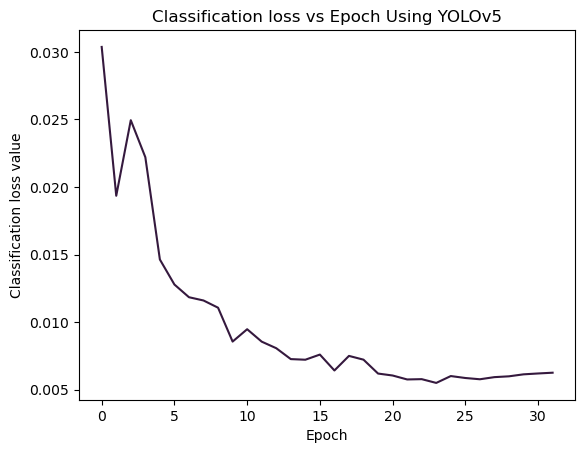

In [70]:
sns.lineplot(data=cls_loss, x='Step',y='Value').set(title='Classification loss vs Epoch Using YOLOv5', xlabel="Epoch",ylabel= "Classification loss value")

[Text(0.5, 1.0, 'Box loss vs Epoch Using YOLOv5'),
 Text(0.5, 0, 'Epoch'),
 Text(0, 0.5, 'Box loss value')]

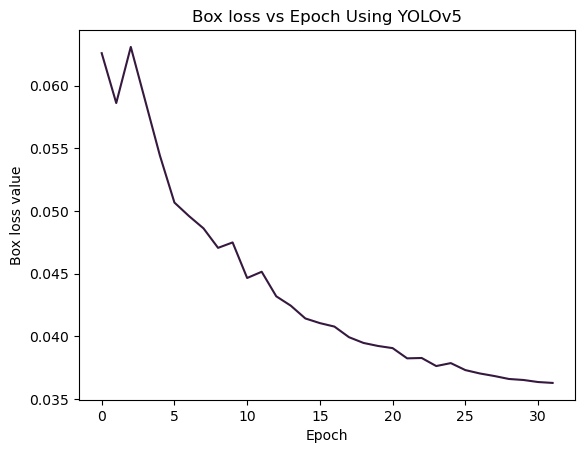

In [71]:
sns.lineplot(data=box_loss, x='Step',y='Value').set(title='Box loss vs Epoch Using YOLOv5', xlabel="Epoch",ylabel= "Box loss value")